In [51]:
import numpy as np # v. 1.22.1
from matplotlib import pyplot as plt # v. 3.7.5
import os
import pandas as pd # v. 1.5.3
import sklearn  as skl

import sys          
# appending the directory of pca.py in the sys.path list
sys.path.append('..')
import PCA_functions as pcf

In [52]:
uvvis_dir = '../../Data/UV-vis'
uvvis_spectra_dir = uvvis_dir + '/spectra'
toc_dir = '../../Data/TOC'

In [53]:
# os.chdir(uvvis_dir)

In [54]:
def sample_info(name:str):
    name = name.split('-')
    site = name[1]
    sample_type = name[2]
    if sample_type == 'PW':
        replicate_letter = name[3]
        dd = name[4]
        mm = name[5]
        yyyy = name[6]
    elif sample_type == 'PL':
        replicate_letter = 'NA'
        dd = name[3]
        mm = name[4]
        yyyy = name[5]
    return site, sample_type, replicate_letter, dd, mm, yyyy

'MP-AM-PW-C-15-10-2024-TOC_10x_i_05112024'

def roman_to_integer(roman_no:str)->int:
    '''
    Convert a roman numeral to its corresponding integer value.
    '''
    roman_no = roman_no.lower()

    tot = roman_no.count('i') + roman_no.count('v') * 5 + roman_no.count('x') * 10 + roman_no.count('l') * 50 + roman_no.count('c') * 100 + roman_no.count('d') * 500 + roman_no.count('m') * 1000
    if 'iv' in roman_no: tot -= roman_no.count('iv') * 2
    if 'ix' in roman_no: tot -= roman_no.count('ix') * 2
    if 'xl' in roman_no: tot -= roman_no.count('xl') * 20
    if 'xc' in roman_no: tot -= roman_no.count('xc') * 20
    if 'cd' in roman_no: tot -= roman_no.count('cd') * 200
    if 'cm' in roman_no: tot -= roman_no.count('cm') * 200

    return tot

def suva(A,TOC,dil=1):
    return 100 * A * dil / TOC # 100 cm / M, returns L / (M mg C)

def sig_figs(x, precision): #from https://mattgosden.medium.com/rounding-to-significant-figures-in-python-2415661b94c3
    """
    Rounds a number to number of significant figures
    Parameters:
    - x - the number to be rounded
    - precision (integer) - the number of significant figures
    Returns:
    - float
    """

    precision = precision

    if type(x) == np.ndarray:
        x = x.astype(float)
        return np.round(x, -np.floor(np.log10(np.abs(np.max(x)))).astype(int) + (precision - 1))

    else:
        x = float(x)
        return np.round(x, -int(np.floor(np.log10(np.abs(x)))) + (precision - 1))



In [55]:
files = os.listdir(uvvis_spectra_dir)

sample_name_list = []
site_list = []
sample_type_list = []
replicate_letter_list = []
dd_list = []
mm_list = []
yyyy_list = []
dilution_factor_list = []
tech_replicate_list = []

for f in files:
    
    spectrum_df = pd.read_csv(f'{uvvis_spectra_dir}/{f}',skiprows=1)
    if f == files[0]:
        wls = spectrum_df['Wavelength nm.'].to_numpy()
        intensities_array = spectrum_df['Abs.'].to_numpy()
    else:
        intensities_array = np.vstack((intensities_array,spectrum_df['Abs.'].to_numpy()))

    f = f.split('_')

    sample_name_list.append(f[0])
    site, sample_type, replicate_letter, dd, mm, yyyy = sample_info(f[0])
    dilution_factor = int(f[1].replace('x',''))

    tech_replicate = roman_to_integer(f[2])

    site_list.append(site)
    sample_type_list.append(sample_type)
    replicate_letter_list.append(replicate_letter)
    dd_list.append(dd)
    mm_list.append(mm)
    yyyy_list.append(yyyy)
    dilution_factor_list.append(dilution_factor)
    tech_replicate_list.append(tech_replicate)

In [56]:
spectra_df = pd.DataFrame(intensities_array,columns=wls.astype(str))

In [57]:

samples_info = {
    'sample_name': np.array(sample_name_list),
    'site': np.array(site_list),
    'sample_type': np.array(sample_type_list),
    'replicate_letter': np.array(replicate_letter_list),
    'day': np.array(dd_list),
    'month': np.array(mm_list),
    'year': np.array(yyyy_list),
    'dilution_factor': np.array(dilution_factor_list),
    'tech_replicate': np.array(tech_replicate_list),
}
info_df = pd.DataFrame(samples_info)
# info_df

In [58]:
df = pd.concat([info_df.reset_index(drop=True),spectra_df.reset_index(drop=True)], axis=1)
# df

In [59]:
def suva_error(A,A_error,TOC,TOC_error,dil=1):
    # return suva_values * (np.sqrt( np.pow(A_error/A,2) + np.pow(TOC_error/TOC,2) * 100 * dil))
    factor = dil * 100
    return np.sqrt(  np.pow( (factor/TOC) * A_error,2) + np.pow( (factor*A / np.pow(TOC,2)) * TOC_error,2) )

In [60]:
chosen_wl = 254.0 #if integer, it must have .0
avg_atwl = []
std_atwl = []
dil_list = []
sample_name_list_unique = np.unique(sample_name_list)

toc_files = os.listdir(toc_dir)
toc_list = []

for name in sample_name_list_unique:
    sel = df[df['sample_name']==name]
    avg_atwl.append(np.mean(sel[str(chosen_wl)]))
    # std_atwl.append(round(np.std(sel[str(chosen_wl)]),4))
    std_atwl.append(np.std(sel[str(chosen_wl)]))
    dil_list.append(np.unique(sel['dilution_factor'])[0])

    for f in toc_files:
        f_df = pd.read_csv(f'{toc_dir}/{f}',sep='\t',skiprows=10)[['Sample ID','Result(NPOC)']]

        if len(f_df[f_df['Sample ID']==name]['Result(NPOC)'].to_list()) > 0:
            toc_list.append(f_df[f_df['Sample ID']==name]['Result(NPOC)'].to_list()[0])

if int(chosen_wl) == chosen_wl: chosen_wl = int(chosen_wl)

avg_atwl = np.array(avg_atwl)
std_atwl = np.array(std_atwl)
dil_arr = np.array(dil_list)
toc_arr = np.array(toc_list)
suva_values = suva(avg_atwl,toc_arr,dil=dil_arr)
TOC_error = 0.005
TOC_error_arr = np.ones(len(sample_name_list_unique)) * TOC_error
std_suva = suva_error(avg_atwl,std_atwl,toc_arr,TOC_error,dil=dil_arr)

A_atwl_df = pd.DataFrame({
    'sample_name': sample_name_list_unique,
    'dilution_factor': dil_list,
    f'avg_A_{chosen_wl}': sig_figs(avg_atwl,3),
    f'std_A_{chosen_wl}': sig_figs(std_atwl,1),
    'TOC_(mg/L)': toc_list,
    f'SUVA_{chosen_wl}_(L/M_mg_C)': sig_figs(suva_values,3),
    f'std_SUVA_{chosen_wl}_(L/M_mg_C)': sig_figs(std_suva,1)
})
A_atwl_df

,sample_name,dilution_factor,avg_A_254,std_A_254,TOC_(mg/L),SUVA_254_(L/M_mg_C),std_SUVA_254_(L/M_mg_C)
0,MP-AM-PW-C-15-10-2024-TOC,10,0.235,0.001,62.69,3.74,0.02
1,MP-AM-PW-E-15-10-2024-TOC,10,0.201,0.001,49.72,4.04,0.02
2,MP-HM-PL-17-10-2024-TOC,10,0.175,0.001,45.51,3.84,0.03
3,MP-HM-PW-A-15-10-2024-TOC,10,0.269,0.000,67.34,3.99,0.00
4,MP-HM-PW-B-15-10-2024-TOC,10,0.191,0.000,77.94,2.45,0.00
5,MP-HM-PW-C-15-10-2024-TOC,10,0.268,0.000,62.58,4.28,0.00
6,MP-HM-PW-D-15-10-2024-TOC,10,0.236,0.001,71.45,3.30,0.01
7,MP-HM-PW-E-17-10-2024-TOC,10,0.191,0.001,46.79,4.08,0.02
8,MP-HM-PW-F-17-10-2024-TOC,10,0.188,0.000,43.28,4.34,0.00
9,MP-HM-PW-G-17-10-2024-TOC,10,0.198,0.000,54.00,3.67,0.00


In [61]:
A_atwl_df.to_csv(f'{uvvis_dir}/SUVA_{chosen_wl}_data.csv',index=False)

# PCA

In [62]:
pd.DataFrame(intensities_array)

,0,1,2,3,4,5,6,7,8,9,...,1391,1392,1393,1394,1395,1396,1397,1398,1399,1400
0,0.484,0.480,0.477,0.476,0.474,0.470,0.467,0.466,0.465,0.458,...,0.004,-0.011,0.009,0.003,0.004,0.002,-0.012,0.004,-0.016,-0.001
1,0.483,0.476,0.479,0.473,0.468,0.469,0.467,0.460,0.460,0.457,...,0.007,-0.005,-0.006,0.007,-0.004,-0.008,-0.008,-0.003,-0.009,-0.010
2,0.484,0.475,0.471,0.469,0.468,0.466,0.463,0.462,0.457,0.454,...,-0.004,-0.006,-0.001,-0.005,-0.003,-0.006,-0.006,-0.011,-0.021,0.005
3,0.398,0.397,0.392,0.394,0.391,0.390,0.387,0.384,0.385,0.381,...,-0.002,-0.008,0.010,0.009,0.000,0.006,-0.009,0.007,-0.001,-0.007
4,0.400,0.393,0.394,0.391,0.388,0.387,0.385,0.383,0.385,0.380,...,-0.005,-0.019,-0.004,-0.006,-0.001,0.002,-0.005,0.006,-0.022,-0.003
5,0.400,0.396,0.394,0.388,0.388,0.385,0.386,0.381,0.381,0.378,...,0.001,-0.011,0.011,0.007,-0.007,-0.003,-0.010,0.001,-0.021,-0.005
6,0.325,0.324,0.320,0.323,0.325,0.319,0.316,0.315,0.317,0.314,...,-0.009,0.009,-0.009,0.001,0.008,0.004,-0.008,0.009,0.005,0.004
7,0.327,0.317,0.317,0.317,0.318,0.315,0.313,0.312,0.313,0.310,...,-0.007,0.009,0.005,0.003,0.013,0.004,0.001,0.008,0.005,-0.003
8,0.317,0.316,0.316,0.316,0.314,0.310,0.312,0.307,0.311,0.307,...,-0.008,0.007,0.015,0.005,0.003,0.011,-0.006,0.009,0.002,0.005
9,0.546,0.542,0.539,0.537,0.535,0.534,0.533,0.528,0.528,0.524,...,-0.005,-0.018,0.001,0.004,-0.001,-0.011,-0.002,0.002,-0.007,-0.012


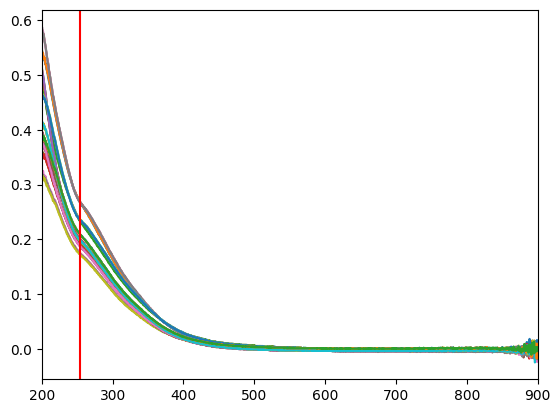

In [63]:
fig1 = plt.figure()
ax1 = fig1.add_subplot()
no_of_spectra = len(intensities_array)
for i in range(no_of_spectra):
    ax1.plot(wls,intensities_array[i,:])
ax1.set_xlim(np.min(wls),np.max(wls))
ax1.axvline(chosen_wl,c='r')

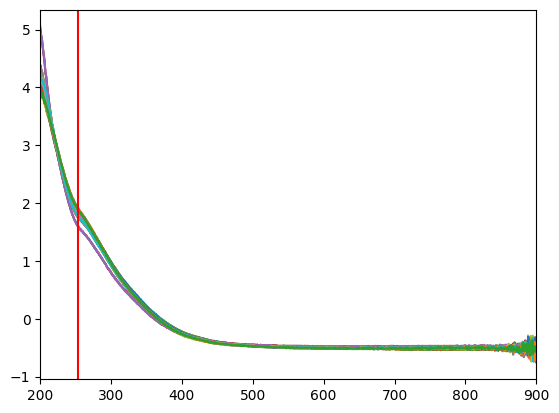

In [64]:
snv = pcf.SNV_matrix(intensities_array)
fig2 = plt.figure()
ax2 = fig2.add_subplot()
for i in range(no_of_spectra):
    ax2.plot(wls,snv[i,:])
ax2.set_xlim(np.min(wls),np.max(wls))
ax2.axvline(chosen_wl,c='r')

In [65]:
scores_values, variance_ratio, PCs, loadings = pcf.get_pca_data(intensities_array,'SNV',5)

In [66]:
chosen_PCs = [1,2]

In [67]:
samples_info

{'sample_name': array(['MP-AM-PW-C-15-10-2024-TOC', 'MP-AM-PW-C-15-10-2024-TOC',
        'MP-AM-PW-C-15-10-2024-TOC', 'MP-AM-PW-E-15-10-2024-TOC',
        'MP-AM-PW-E-15-10-2024-TOC', 'MP-AM-PW-E-15-10-2024-TOC',
        'MP-HM-PL-17-10-2024-TOC', 'MP-HM-PL-17-10-2024-TOC',
        'MP-HM-PL-17-10-2024-TOC', 'MP-HM-PW-A-15-10-2024-TOC',
        'MP-HM-PW-A-15-10-2024-TOC', 'MP-HM-PW-A-15-10-2024-TOC',
        'MP-HM-PW-B-15-10-2024-TOC', 'MP-HM-PW-B-15-10-2024-TOC',
        'MP-HM-PW-B-15-10-2024-TOC', 'MP-HM-PW-C-15-10-2024-TOC',
        'MP-HM-PW-C-15-10-2024-TOC', 'MP-HM-PW-C-15-10-2024-TOC',
        'MP-HM-PW-D-15-10-2024-TOC', 'MP-HM-PW-D-15-10-2024-TOC',
        'MP-HM-PW-D-15-10-2024-TOC', 'MP-HM-PW-E-17-10-2024-TOC',
        'MP-HM-PW-E-17-10-2024-TOC', 'MP-HM-PW-E-17-10-2024-TOC',
        'MP-HM-PW-F-17-10-2024-TOC', 'MP-HM-PW-F-17-10-2024-TOC',
        'MP-HM-PW-F-17-10-2024-TOC', 'MP-HM-PW-G-17-10-2024-TOC',
        'MP-HM-PW-G-17-10-2024-TOC', 'MP-HM-PW-G-17-10-2024-TOC',
 

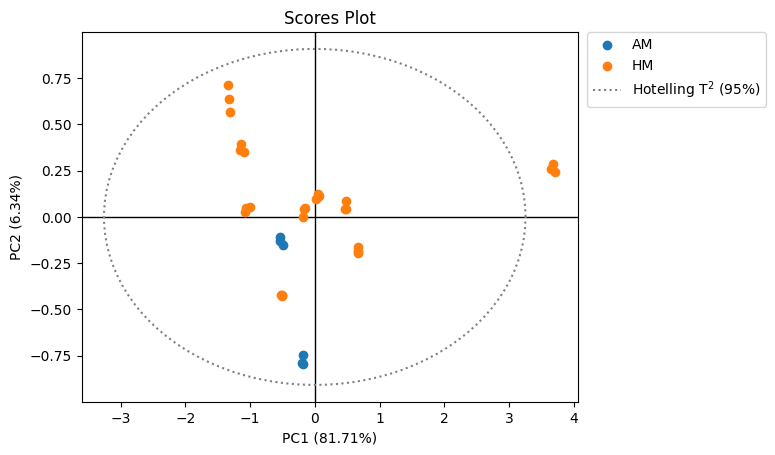

In [68]:
fig_scores = plt.figure()
ax_scores = fig_scores.add_subplot()

filter_var = 'site'

for x in np.unique(samples_info[filter_var]):
    pcf.scores_plot(scores_values[np.where(samples_info[filter_var]==x)],chosen_PCs,fig=fig_scores,ax=ax_scores,lines=False,variance_ratio=variance_ratio,label=x)

pcf.Hotelling(scores_values,chosen_PCs,ax_scores)

ax_scores.axhline(y=0, color = '#000', linewidth = 1, zorder=-1)
ax_scores.axvline(x=0, color = '#000', linewidth = 1, zorder=-1)
ax_scores.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

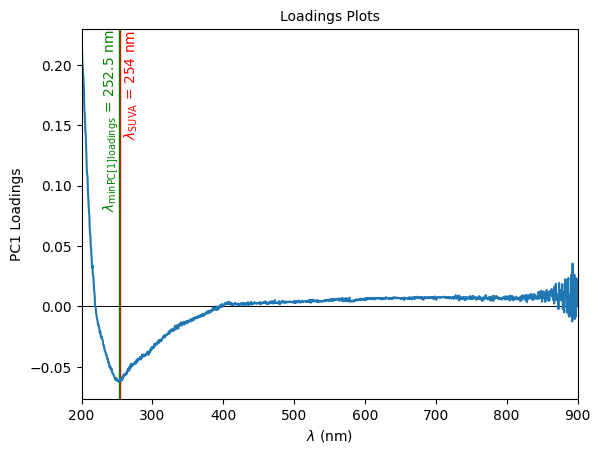

In [86]:
loadings_PCs = [1] #chosen_PCs [1]
fig_loadings = plt.figure()
ax_loadings = fig_loadings.subplots(len(loadings_PCs),sharex=True)

pcf.loadings_plot(wls,loadings,loadings_PCs,variance_ratio=variance_ratio,xlabel='$\\lambda$ (nm)',fig=fig_loadings,ax=ax_loadings)


if len(loadings_PCs) == 1:

    ax_loadings.axvline(chosen_wl,c='r',linewidth=1,zorder=-1)

    min_wl = wls[np.where(loadings[0]==np.min(loadings[0]))][0]
    ax_loadings.axvline(min_wl,c='green',linewidth=1,zorder=-1)

    max_ylim = np.max(ax_loadings.get_ylim())
    x_range = np.max(ax_loadings.get_xlim()) - np.min(ax_loadings.get_xlim())

    if chosen_wl > min_wl:
        ax_loadings.text(chosen_wl+.005*x_range,max_ylim,f'$\\lambda_{{\\mathrm{{SUVA}}}}$ = {chosen_wl} nm',c='r',ha='left',va='top',rotation=90)
        ax_loadings.text(min_wl+.005*x_range,max_ylim,f'$\\lambda_{{\\mathrm{{min PC[{loadings_PCs[0]}] loadings}}}}$ = {min_wl} nm',c='green',ha='right',va='top',rotation=90)
    elif chosen_wl == min_wl:
        ax_loadings.text(chosen_wl+.005*x_range,max_ylim,f'$\\lambda_{{\\mathrm{{SUVA}}}}$ = $\\lambda_{{\\mathrm{{min PC[{loadings_PCs[0]}] loadings}}}}$ = {chosen_wl} nm',c='k',ha='right',va='top',rotation=90)
    else:
        ax_loadings.text(chosen_wl+.005*x_range,max_ylim,f'$\\lambda_{{\\mathrm{{SUVA}}}}$ = {chosen_wl} nm',c='r',ha='right',va='top',rotation=90)
        ax_loadings.text(min_wl+.005*x_range,max_ylim,f'$\\lambda_{{\\mathrm{{min PC[{loadings_PCs[0]}] loadings}}}}$ = {min_wl} nm',c='green',ha='left',va='top',rotation=90)

else:
    for i in range(len(loadings_PCs)):
            
            ax_loadings[i].axvline(chosen_wl,c='r',linewidth=1,zorder=-1)

            min_wl = wls[np.where(loadings[loadings_PCs[i]-1]==np.min(loadings[loadings_PCs[i]-1]))][0]
            ax_loadings[i].axvline(min_wl,c='green',linewidth=1,zorder=-1)

            max_ylim = np.max(ax_loadings[i].get_ylim())
            x_range = np.max(ax_loadings[i].get_xlim()) - np.min(ax_loadings[i].get_xlim())

            if chosen_wl > min_wl:
                ax_loadings[i].text(chosen_wl+.005*x_range,max_ylim,f'$\\lambda_{{\\mathrm{{SUVA}}}}$ = {chosen_wl} nm',c='r',ha='left',va='top',rotation=90)
                ax_loadings[i].text(min_wl+.005*x_range,max_ylim,f'$\\lambda_{{\\mathrm{{min PC[{loadings_PCs[i]}] loadings}}}}$ = {min_wl} nm',c='green',ha='right',va='top',rotation=90)
            elif chosen_wl == min_wl:
                ax_loadings[i].text(chosen_wl+.005*x_range,max_ylim,f'$\\lambda_{{\\mathrm{{SUVA}}}}$ = $\\lambda_{{\\mathrm{{min PC[{loadings_PCs[i]}] loadings}}}}$ = {chosen_wl} nm',c='k',ha='right',va='top',rotation=90)
            else:
                ax_loadings[i].text(chosen_wl+.005*x_range,max_ylim,f'$\\lambda_{{\\mathrm{{SUVA}}}}$ = {chosen_wl} nm',c='r',ha='right',va='top',rotation=90)
                ax_loadings[i].text(min_wl+.005*x_range,max_ylim,f'$\\lambda_{{\\mathrm{{min PC[{loadings_PCs[i]}] loadings}}}}$ = {min_wl} nm',c='green',ha='left',va='top',rotation=90)
